In [2]:
import numpy as np
import matplotlib.pyplot as plt

We firstly generate several data for our task:

In [3]:
def data_generation(t, rho, tau, sigma):

    x_list = np.random.normal(size = t + 1)

    y_list = np.random.normal(size = t + 1)

    for i in range(t):
        x_list[i + 1] =  rho * x_list[i] + tau * np.random.normal()

    W_list = sigma * np.random.normal(size = t + 1)

    y_list = x_list + W_list

    return x_list, y_list


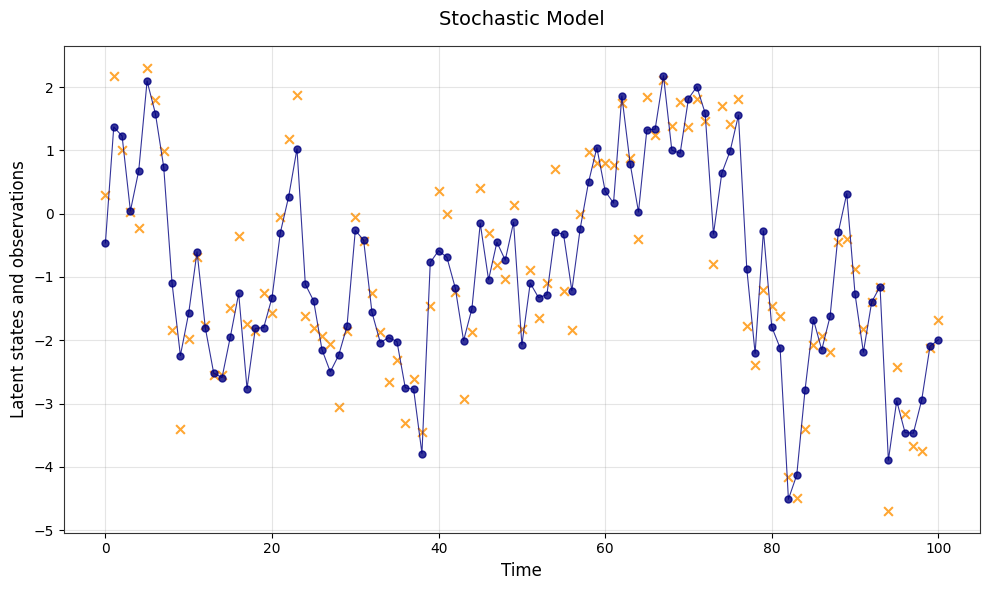

In [12]:
rho = 0.8
tau = 1.
sigma = 0.5
T = 100

x_sample, y_sample = data_generation(T, rho, tau, sigma)
time = np.array(range(T + 1))

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(time, x_sample, color='#000080', marker='o',
        markersize=5, linestyle='-', linewidth=0.8, alpha=0.8)
ax.scatter(time, y_sample, color='#FF9100', marker='x', label='Observations',
           s=40, alpha=0.8)

ax.set_title('Stochastic Model', fontsize=14, pad=15)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Latent states and observations', fontsize=12)
ax.grid(True, which='both', linestyle='-', alpha=0.2, color='gray')


for spine in ax.spines.values():
    spine.set_edgecolor('#333333')

plt.tight_layout()
plt.savefig('./light_style_model.png', dpi=300)
plt.show()

Question 1

In [20]:
def kalman_filter(y, param, A, B, C = 1, D = 0.5):
    m = param[0]
    v = param[1]

    loglik = 0
    T = len(y)

    for i in range(T):

        # m_pred and v_pred are mean and variance of prediction distribution
        m_pred = A * m
        v_pred = A ** 2 * v + B ** 2

        # M and V are joint likelihood that we care
        M = C * m_pred
        V = C **2 * v_pred + D ** 2

        loglik += (- np.log(2 * np.pi) - np.log(V) - (y[i] - M) ** 2 / V)  * 0.5

        #m and v are mean and vairance of filter distribution
        K = v_pred * C / V

        m = m_pred + K * (y[i] - M)
        v = v_pred - K * C * v_pred

    return loglik

In [21]:
from scipy.stats import norm
def log_rho(x):
    if x > -1 or x < 1:
        return -np.log(2)
    else:
        return -np.inf

def log_tau(x, mu = 1, sigma = 1, a = 0, b = 2):

    if x <= a or x >= b:
        return -np.inf

    z = (x - mu) / sigma

    # log normal pdf (without truncation)
    log_pdf = -0.5 * z**2 - np.log(sigma * np.sqrt(2*np.pi))

    # normalization constant
    Z = norm.cdf(1) - norm.cdf(-1)

    return log_pdf - np.log(Z)

In [22]:
def metropolis_hasting (y, num, scale, param = np.array([0, 1])):

    rho_list = np.zeros(num)

    tau_list = np.ones(num)

    acc = 0


    for i in range(num - 1):

        rho_prop = rho_list[i] + np.random.normal(loc = 0, scale = scale)
        tau_prop = tau_list[i] + np.random.normal(loc = 0, scale = scale)

        log_y_old = kalman_filter(y, param, A = rho_list[i], B = tau_list[i])
        loglik_old = log_rho(rho_list[i])+log_tau(tau_list[i])+log_y_old

        log_y_prop = kalman_filter(y, param, A = rho_prop, B = tau_prop)
        loglik_prop = log_rho(rho_prop)+log_tau(tau_prop)+log_y_prop

        if log_rho(rho_prop) == -np.inf or log_tau(tau_prop) == -np.inf:

            rho_list[i + 1] = rho_list[i]
            tau_list[i + 1] = tau_list[i]

        else:

            u = np.random.uniform(low = 0, high = 1)

            if np.log(u) < loglik_prop - loglik_old:
                rho_list[i + 1] = rho_prop
                tau_list[i + 1] = tau_prop

                acc += 1
            else:
                rho_list[i + 1] = rho_list[i]
                tau_list[i + 1] = tau_list[i]

    return rho_list, tau_list, acc/num

In [23]:
rho, tau, acc = metropolis_hasting(y_sample, scale = 0.05, num = 20000)

In [24]:
print(acc)

0.68535


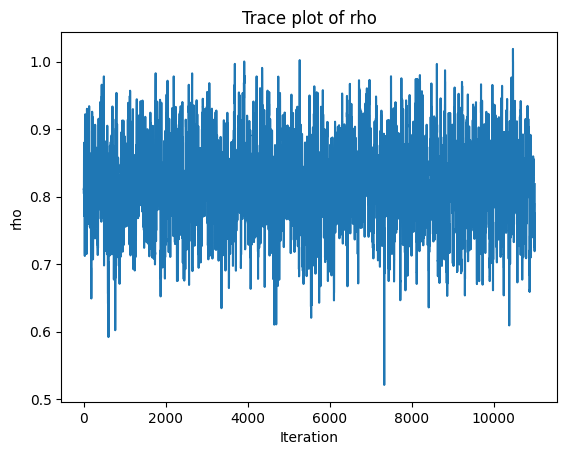

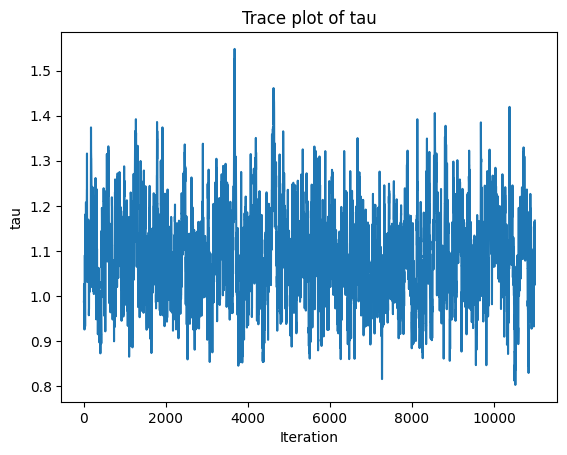

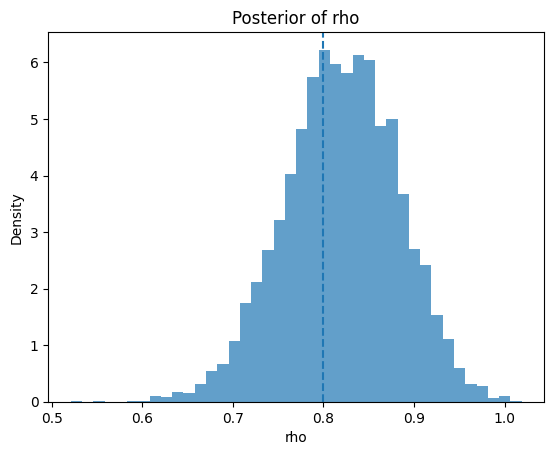

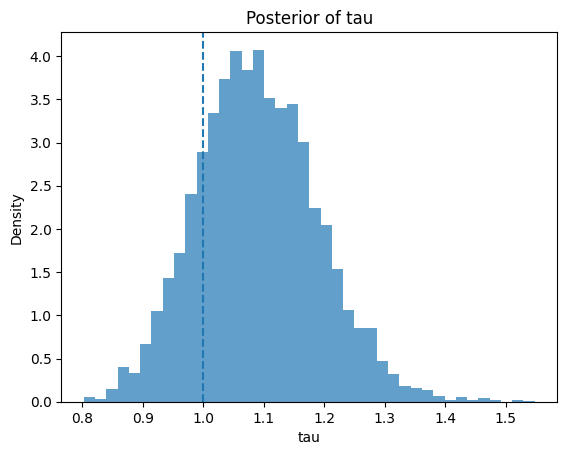

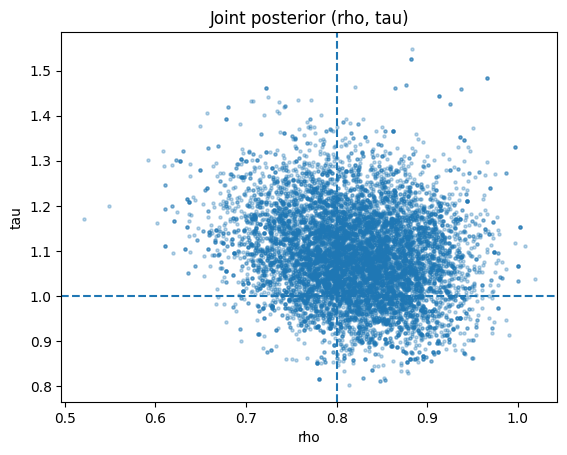

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Convert to array
rho = np.array(rho)
tau = np.array(tau)

# Burn-in
burn = 2000
rho = rho[burn:]
tau = tau[burn:]

# -------------------------
# 1. Trace plots (convergence check)
# -------------------------

plt.figure()
plt.plot(rho)
plt.title("Trace plot of rho")
plt.xlabel("Iteration")
plt.ylabel("rho")
plt.savefig("./rho_trace")
plt.show()

plt.figure()
plt.plot(tau)
plt.title("Trace plot of tau")
plt.xlabel("Iteration")
plt.ylabel("tau")
plt.savefig("./tau_trace")
plt.show()


# -------------------------
# 2. Marginal histograms
# -------------------------

plt.figure()
plt.hist(rho, bins=40, density=True, alpha=0.7)
plt.axvline(0.8, linestyle="--")   # true rho (if known)
plt.title("Posterior of rho")
plt.xlabel("rho")
plt.ylabel("Density")
plt.savefig('./margin_of_rho.png', dpi=300)
plt.show()


plt.figure()
plt.hist(tau, bins=40, density=True, alpha=0.7)
plt.axvline(1.0, linestyle="--")   # true tau (if known)
plt.title("Posterior of tau")
plt.xlabel("tau")
plt.ylabel("Density")
plt.savefig('./margin_of_tau.png', dpi=300)
plt.show()


# -------------------------
# 3. Joint posterior (rho, tau)
# -------------------------

plt.figure()
plt.scatter(rho, tau, s=5, alpha=0.3)
plt.axvline(0.8, linestyle="--")
plt.axhline(1.0, linestyle="--")
plt.xlabel("rho")
plt.ylabel("tau")
plt.title("Joint posterior (rho, tau)")
plt.savefig('./joint.png', dpi=300)
plt.show()


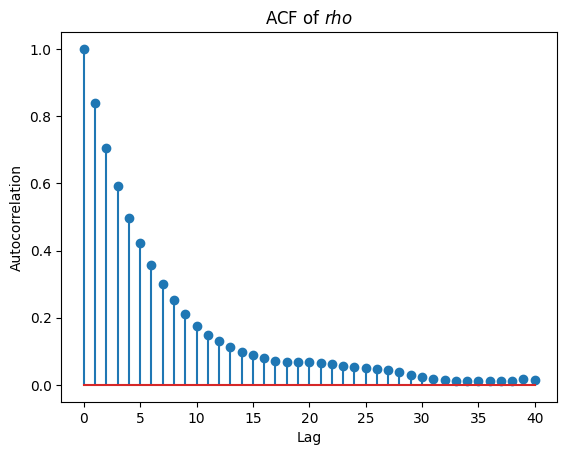

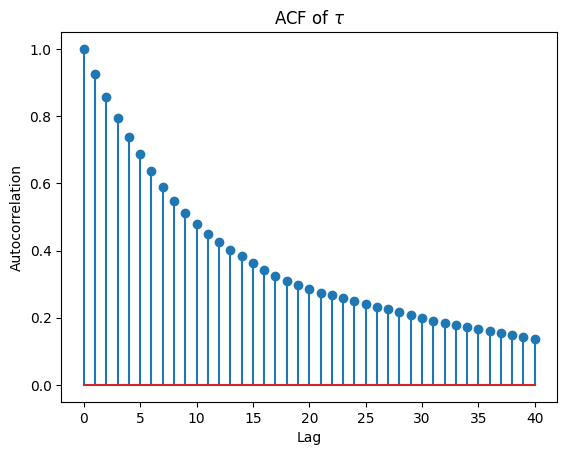

In [254]:
from statsmodels.tsa.stattools import acf

acf_rho = acf(rho, nlags=40)

plt.figure()
plt.stem(acf_rho)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title(r"ACF of $rho$")
plt.savefig("./acf_rho")
plt.show()

acf_rho = acf(tau, nlags=40)

plt.figure()
plt.stem(acf_rho)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title(r"ACF of $\tau$")
plt.savefig("./acf_tau")
plt.show()



Question 2

In [72]:
def weight(x, y, sigma = 0.5):
    loglik = -0.5*(np.log(2 * np.pi * sigma ** 2) + (y - x)**2/sigma**2)
    lik = np.exp(loglik)

    return lik

In [230]:
def particle_filter(y, N, T, resample=False):

    traj = np.zeros((T + 1, N))
    W_list = np.zeros((T + 1, N))
    y_t = y[:T + 1]

    traj[0, : ] = np.random.normal(size = N)
    W_list[0, :] = weight(traj[0, :], y_t[0]) / np.sum(weight(traj[0, :], y_t[0]))


    for i in range(T):
        traj[i + 1, : ] = np.random.normal(loc = traj[i, : ], size = N)
        w = weight(traj[i + 1, : ], y_t[i + 1]) * W_list[i, :]
        W_list[i + 1, :] = w / np.sum(w)

        if resample:

            idx = np.random.choice(N, size=N, p=W_list[i + 1, :])

            traj[i + 1, :] = traj[i + 1, : ][idx]
            W_list[i + 1, ] = np.ones(N) / N



    return traj, W_list

In [252]:
import os
def plot_filter_density_cases(y, n_values=(50, 100), N_values=(50, 500), bins=30):

    # 建文件夹
    os.makedirs("question_2_b", exist_ok=True)

    for n in n_values:

        fig, axes = plt.subplots(
            2, 2, figsize=(10, 6),
            sharex=True, sharey=True
        )

        for r, method in enumerate(["SIS", "SIR"]):
            for c, N in enumerate(N_values):

                resample = (method == "SIR")

                traj, W = particle_filter(
                    y, N=N, T=n, resample=resample
                )

                x = traj[-1]
                w = W[-1]

                ax = axes[r, c]

                ax.hist(
                    x,
                    bins=bins,
                    density=True,
                    weights=w,
                    alpha=0.9
                )

                ax.set_title(f"{method}, N={N}, n={n}")
                ax.set_xlabel("x")
                ax.set_ylabel("density")

        plt.suptitle(
            f"Particle approximation of $p(x_n | y_{0:n})$ at n={n}",
            y=1.02,
            fontsize=14
        )

        plt.tight_layout()

        filename = f"./question_2_b/pf_density_n{n}.png"

        plt.savefig(filename, dpi=300, bbox_inches="tight")

        plt.show()
        plt.close(fig)

        print(f"Saved: {filename}")

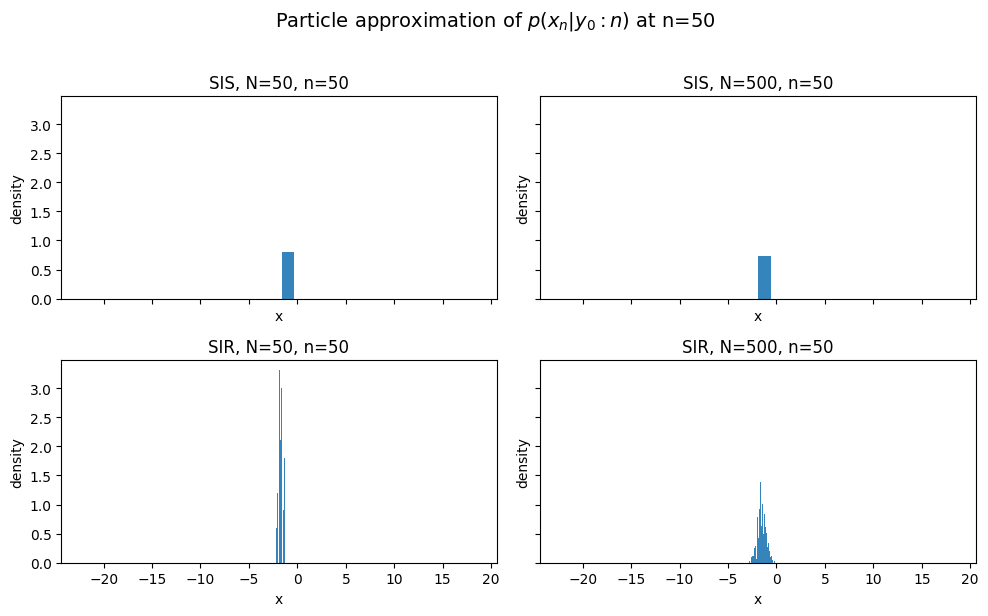

Saved: ./question_2_b/pf_density_n50.png


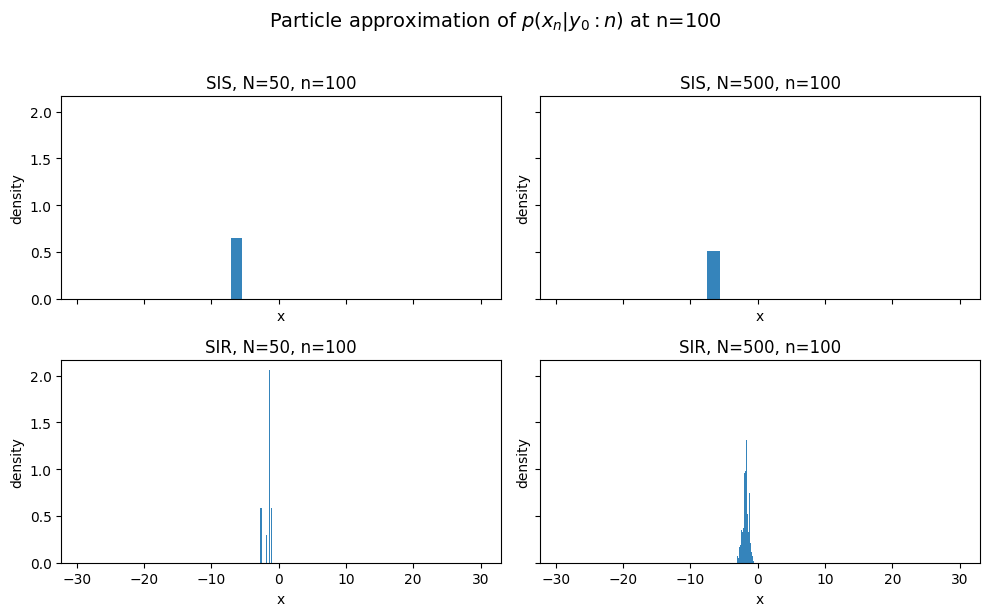

Saved: ./question_2_b/pf_density_n100.png


In [255]:
plot_filter_density_cases(
    y_sample,
    n_values=(50, 100),
    N_values=(50, 500),
    bins=30
)

In [195]:
traj, w = particle_filter(y_sample, 50, 100, resample = False)

traj = traj[-1:, ]
w = w[-1:, ]
traj = (np.abs(traj) <= 0.1).astype(int)
print(np.sum(traj * w))


0.0


In [235]:
def prob(y, N, T, resample=False):

    traj, w = particle_filter(y, N, T, resample=resample)

    indicator = (np.abs(traj) <= 0.1).astype(int)

    pr = np.sum(indicator * w, axis=1)

    return pr

In [248]:
import numpy as np
from scipy.stats import norm

def kalman_filter_prob(y, param, A, B, C=1, D=0.5, eps=0.1):

    m = param[0]   # initial mean
    v = param[1]   # initial var

    T = len(y)

    prob = np.zeros(T)

    for i in range(T):

        # prediction
        m_pred = A * m
        v_pred = A**2 * v + B**2

        # observation model
        M = C * m_pred
        V = C**2 * v_pred + D**2

        # Kalman gain
        K = v_pred * C / V

        # update
        m = m_pred + K * (y[i] - M)
        v = v_pred - K * C * v_pred

        # posterior event probability
        sd = np.sqrt(v)

        prob[i] = (
            norm.cdf((eps - m)/sd)
            - norm.cdf((-eps - m)/sd)
        )

    return prob

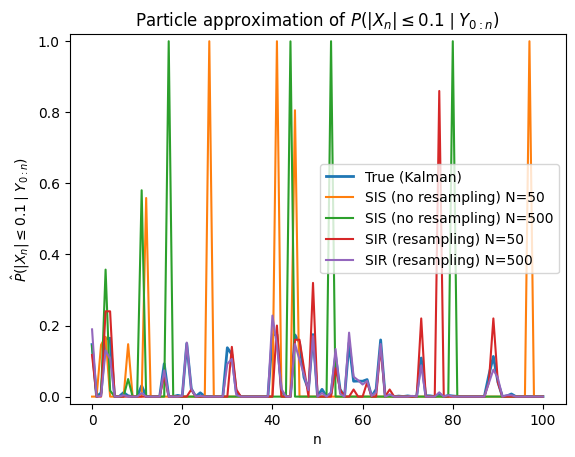

In [251]:
t = 100
import numpy as np
import matplotlib.pyplot as plt

def plot_all_cases(y, T, eps=0.1):
    n = np.arange(T + 1)

    pr_true = kalman_filter_prob(
        y_sample, param=[0,1], A = 0.8, B = 1, C = 1, D = 0.5
    )

    pr_sis_50  = prob(y, N=50,  T=T, resample=False)
    pr_sis_500 = prob(y, N=500, T=T, resample=False)
    pr_sir_50  = prob(y, N=50,  T=T, resample=True)
    pr_sir_500 = prob(y, N=500, T=T, resample=True)

    plt.figure()
    plt.plot(n, pr_true, label="True (Kalman)", linewidth=2)
    plt.plot(n, pr_sis_50,  label="SIS (no resampling) N=50")
    plt.plot(n, pr_sis_500, label="SIS (no resampling) N=500")
    plt.plot(n, pr_sir_50,  label="SIR (resampling) N=50")
    plt.plot(n, pr_sir_500, label="SIR (resampling) N=500")

    plt.xlabel("n")
    plt.ylabel(r"$\hat P(|X_n| \leq 0.1 \mid Y_{0:n})$")
    plt.title(r"Particle approximation of $P(|X_n| \leq 0.1\mid Y_{0:n})$")
    plt.ylim(-0.02, 1.02)
    plt.legend()
    plt.savefig('./prob.png')
    plt.show()


plot_all_cases(y_sample, t)
